# **Tidy Tuesday: World Languages**
December 23, 2025


* Which macroareas have the highest concentration of endangered languages?
* Are language isolates more likely to be endangered?
* Which language families span the widest geographic range?
* What geographic patterns emerge when mapping endangered languages?

In [1]:
# Libraries
import numpy as np
import pandas as pd
from pandasql import sqldf

In [2]:
# Data
endangered_status = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-12-23/endangered_status.csv')
families = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-12-23/families.csv')
languages = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-12-23/languages.csv')

Data Preview

In [3]:
endangered_status

,id,status_code,status_label
0,fasu1242,3,shifting
1,wash1253,4,moribund
2,taua1242,1,not endangered
3,puel1244,6,extinct
4,tuxa1239,6,extinct
...,...,...,...
8562,punu1239,1,not endangered
8563,vumb1238,3,shifting
8564,sang1333,1,not endangered
8565,bara1362,2,threatened


In [4]:
families

,id,family
0,abkh1242,Abkhaz-Adyge
1,surm1244,Surmic
2,tama1329,Tamaic
3,yare1250,Yareban
4,monu1249,Bogia
...,...,...
4827,lumb1252,Lumbu-Bwisi
4828,sang1341,Sangu-Sira-Punu
4829,punu1240,Punu-Vungu
4830,sang1345,Sangu-Sira


In [5]:
languages

,id,name,macroarea,latitude,longitude,iso639p3code,countries,is_isolate,family_id
0,fasu1242,Fasu,Papunesia,-6.626870,143.284000,faa,PG,True,NaN
1,wash1253,Washo,NaN,38.818400,-119.640000,was,US,True,NaN
2,taua1242,Tauade,NaN,-8.348600,147.094000,ttd,PG,True,NaN
3,puel1244,Puelche,NaN,-42.223000,-68.666000,pue,AR,True,NaN
4,tuxa1239,Tuxá,NaN,-8.953642,-38.274229,tud,BR,True,NaN
...,...,...,...,...,...,...,...,...,...
8607,punu1239,Punu,Africa,-2.673620,11.671400,puu,CG;GA,False,atla1278
8608,vumb1238,Vumbu,Africa,-2.176730,10.649800,vum,GA,False,atla1278
8609,sang1333,Sangu (Gabon),Africa,-1.526940,11.909800,snq,GA,False,atla1278
8610,bara1362,Barama,Africa,-2.496590,10.677700,bbg,GA,False,atla1278


It appears that `languages` is the fact table, with `endangered_status` and `families` as the supplementary dimension tables.

## **Questions**

## 1) Which macroareas have the highest concentration of endangered languages?

In [6]:
sqldf('''
SELECT macroarea, COUNT(macroarea) FROM languages
INNER JOIN endangered_status ON languages.id = endangered_status.id
WHERE endangered_status.status_label != 'not endangered'
GROUP BY macroarea
ORDER BY COUNT(macroarea) DESC
''')

,macroarea,COUNT(macroarea)
0,Papunesia,1411
1,Eurasia,1284
2,Africa,982
3,North America,636
4,South America,616
5,Australia,373
6,Eurasia;Papunesia,1
7,Africa;Eurasia,1
8,None,0


What I did: Gather the macroareas and the count of instances where their endangered status is not "not endangered". Group the counts by macroarea and order the macroares by the endangered count, descending.\
I used an inner join because I can only determine the count of languages that are included in both tables (i.e. the languages must have both an endangered status and belong to a macroarea).

## 2) Are language isolates more likely to be endangered?

In [7]:
# Create an extra column for endangered_status where any language classed as anything not "not endangered" is included
danger = []

for label in endangered_status.status_label:
    # Check if a language is threatened in any way
    if label != 'not endangered':
        danger.append('danger')
    # Otherwise a language is safe
    else:
        danger.append('safe')

# Add list as a new column
endangered_status['label'] = danger
endangered_status.head(3)

,id,status_code,status_label,label
0,fasu1242,3,shifting,danger
1,wash1253,4,moribund,danger
2,taua1242,1,not endangered,safe


In [8]:
# Gather the counts of languages considered to be in danger by isolation status

sqldf('''
SELECT is_isolate, COUNT(is_isolate) FROM languages
INNER JOIN endangered_status ON languages.id = endangered_status.id
WHERE endangered_status.label == 'danger'
GROUP BY is_isolate
''')

,is_isolate,COUNT(is_isolate)
0,0,5257
1,1,177


In [9]:
# Gather the counts of languages by isolation status that exist in both tables

sqldf('''
SELECT is_isolate, COUNT(is_isolate) FROM languages
INNER JOIN endangered_status ON languages.id = endangered_status.id
GROUP BY is_isolate
''')

,is_isolate,COUNT(is_isolate)
0,0,7956
1,1,182


In [10]:
print('Isolated ratio', round(177/182 * 100, 2),'%')
print('Non isolated ratio', round(5257/7956 * 100, 2),'%')

Isolated ratio 97.25 %
Non isolated ratio 66.08 %


An isolate language has a much greater change of being endangered. There is about a 30% difference between the two categories.

## 3) Which language families span the widest geographic range?
Latitude describes the placement of the x-axis.

In [35]:
# For each language family, I gathered the minimum and maximum latitudes along with the difference in the min/max to gather the widths
# Sorted by the value ofthe width, decreasing

sqldf('''
SELECT family, MIN(latitude), MAX(latitude), (MAX(latitude)-MIN(latitude)) AS Width FROM languages
INNER JOIN families ON languages.family_id = families.id
GROUP BY families.family
ORDER BY Width DESC
LIMIT 10
''')

# Displaying the top 10 results

,family,MIN(latitude),MAX(latitude),Width
0,Sign Language,-39.292300,64.17310,103.465400
1,Bookkeeping,-39.048800,60.87784,99.926640
2,Indo-European,-31.632720,66.32000,97.952720
3,Pidgin,-25.384842,70.66200,96.046842
4,Speech Register,-26.247000,62.62170,88.868700
5,Unclassifiable,-28.770000,56.37400,85.144000
6,Austronesian,-44.000000,25.02570,69.025700
7,Artificial Language,-17.570230,49.32730,66.897530
8,Mixed Language,-17.448400,48.24830,65.696700
9,Atlantic-Congo,-31.038900,22.95140,53.990300


The *Sign Langauge* family spans the widest geographic range. Interestingly, the dataset includes *Bookkeeping* as a language family as well.

*Indo-European* is the first spoken language family to appear on the list of top 10 widest ranging language family.

## 4) What geographic patterns emerge when mapping endangered languages?

In [36]:
import matplotlib.pyplot as plt

In [37]:
languages

,id,name,macroarea,latitude,longitude,iso639p3code,countries,is_isolate,family_id
0,fasu1242,Fasu,Papunesia,-6.626870,143.284000,faa,PG,True,NaN
1,wash1253,Washo,NaN,38.818400,-119.640000,was,US,True,NaN
2,taua1242,Tauade,NaN,-8.348600,147.094000,ttd,PG,True,NaN
3,puel1244,Puelche,NaN,-42.223000,-68.666000,pue,AR,True,NaN
4,tuxa1239,Tuxá,NaN,-8.953642,-38.274229,tud,BR,True,NaN
...,...,...,...,...,...,...,...,...,...
8607,punu1239,Punu,Africa,-2.673620,11.671400,puu,CG;GA,False,atla1278
8608,vumb1238,Vumbu,Africa,-2.176730,10.649800,vum,GA,False,atla1278
8609,sang1333,Sangu (Gabon),Africa,-1.526940,11.909800,snq,GA,False,atla1278
8610,bara1362,Barama,Africa,-2.496590,10.677700,bbg,GA,False,atla1278


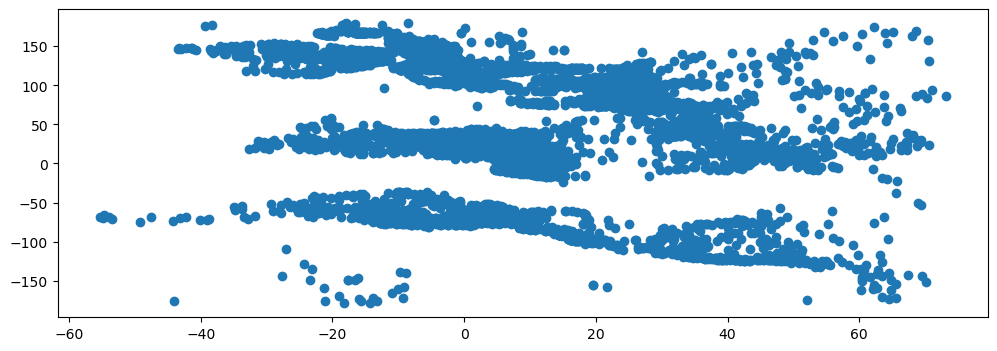

In [39]:
plt.figure(figsize=(12,4))
plt.scatter(languages['latitude'], languages['longitude'])